In [ ]:
%pip install pytorch_lightning

# Importing required libraires

In [ ]:
# paytorch packages
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger

# general packages
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Downloading the dataset for CNN neural networks

In [ ]:
filename = 'CNN.csv'
url = "https://www.dropbox.com/scl/fi/x2eh2yil56rgu5id1fwbm/cnn_data1.csv?rlkey=7bltxkitlwdnuirw08r2ysuv4&st=nppxtfhe&dl=1"
response = requests.get(url)

# Save the file locally
with open(filename, 'wb') as file:
    file.write(response.content)

# Looking into the dataset functions

## Looking into the dataframe's columns distribution

In [ ]:
def plot_data_hist(df, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    # Drop excluded columns
    columns = [col for col in df.columns if col not in exclude_columns]

    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), dpi=80)
    axs = axs.ravel()

    for i, col in enumerate(columns):
        axs[i].hist(df[col].dropna(), bins=30)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('count')

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Summarizing columns

In [ ]:
def summarize_columns(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            print(f'{col} | max: {df[col].max()} | min: {df[col].min()}')
    print('len dataset:', len(df))

# Looking into the output variable historgram

In [ ]:
def plot_hist_with_counts(df, column, bins=5):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    ax = df[column].plot.hist(bins=bins)

    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        bin_center = patch.get_x() + width / 2
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

In [ ]:
csv_file_path = filename  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)

df.head()

,Filename,Depth,Activations-Params,Activation Function,Total Activations,Total Parameters,Batch Size,Max GPU Memory (MiB),Avg GPUTL,Avg GRACT,...,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Status,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),architecture
0,input_channels:3_num_classes:453_depth:22_arch...,69,"[('conv2d', 183956976, 2744), ('GELU', 1839569...",GELU,195826172,1864805,62,39517,-1.000000,-1.000000,...,0,22,1,1,SUCCESSFUL,21.70,123506.48,7.11,123535.29,uniform
1,input_channels:1_num_classes:167_depth:11_arch...,47,"[('conv2d', 44835280, 700), ('batchnorm2d', 44...",SELU,306385536,32924348,46,36831,-1.000000,-1.000000,...,11,11,1,1,OOM_CRASH,2.30,134408.32,125.60,134536.22,pyramid
2,input_channels:3_num_classes:99_depth:14_arch:...,31,"[('conv2d', 33323400, 3388), ('ELU', 33323400,...",ELU,27443119,1730036,34,6293,90.222222,0.913875,...,0,0,1,1,SUCCESSFUL,3.06,10678.04,6.60,10687.70,uniform
3,input_channels:3_num_classes:95_depth:16_arch:...,67,"[('conv2d', 18688000, 2044), ('batchnorm2d', 1...",ELU,119603463,731920,10,6475,93.703125,0.932032,...,16,16,1,1,SUCCESSFUL,2.90,11406.30,2.79,11411.99,uniform
4,input_channels:1_num_classes:149_depth:12_arch...,39,"[('conv2d', 2230272, 640), ('batchnorm2d', 223...",ReLU,11111315,2960902,18,2779,88.328125,0.864873,...,12,0,1,1,SUCCESSFUL,0.18,2034.54,11.29,2046.01,gradual


# Adding (total-activations * batch-size) to the data as another feature!
## 1. The OOM crashed configurations mean that they wanted more than 40GB (Memory Capacity of NVIDIA A100 GPU).
## 2. filtering out residual and dense architectures for initial analysis as parsing the features out of them requires being careful!

In [ ]:
df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']
df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 42000



df = df.dropna(subset=['Activation Function'])

df = df[~df['architecture'].isin(['residual', 'dense'])]


df = df[['Depth', 'Activation Function', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
               'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
               'Linear Count', 'Max GPU Memory (MiB)', 'architecture',
               'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)']]


columns_to_analyze = ['Depth', 'Activation Function', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
                        'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
                        'Linear Count', 'Max GPU Memory (MiB)', 'architecture',
                        'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)']

In [ ]:
for col in columns_to_analyze:
    if col == 'activation_function':
      continue
    print(f'{col} | max : ', df[col].max(), '| min: ', df[col].min())
print('len dataset: ', len(df))


# Plotting the histogram of 'Max GPU Memory (MiB)' with increased figure size and labeled bins
plt.figure(figsize=(100, 8))  # Increase the size of the figure
ax = df[['Max GPU Memory (MiB)']].hist(bins=50, edgecolor='black')

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

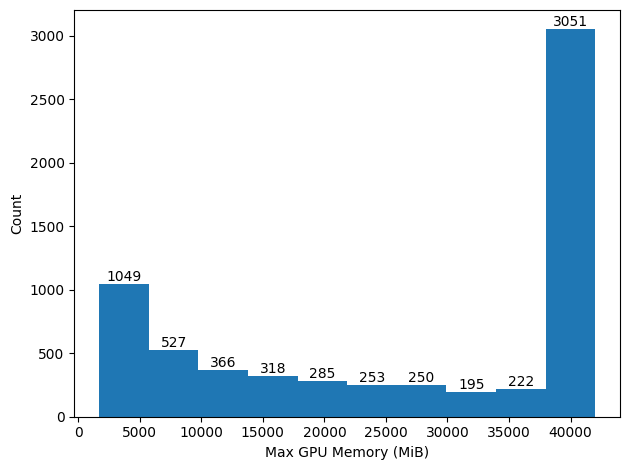

In [ ]:
plot_hist_with_counts(df, 'Max GPU Memory (MiB)', 10)

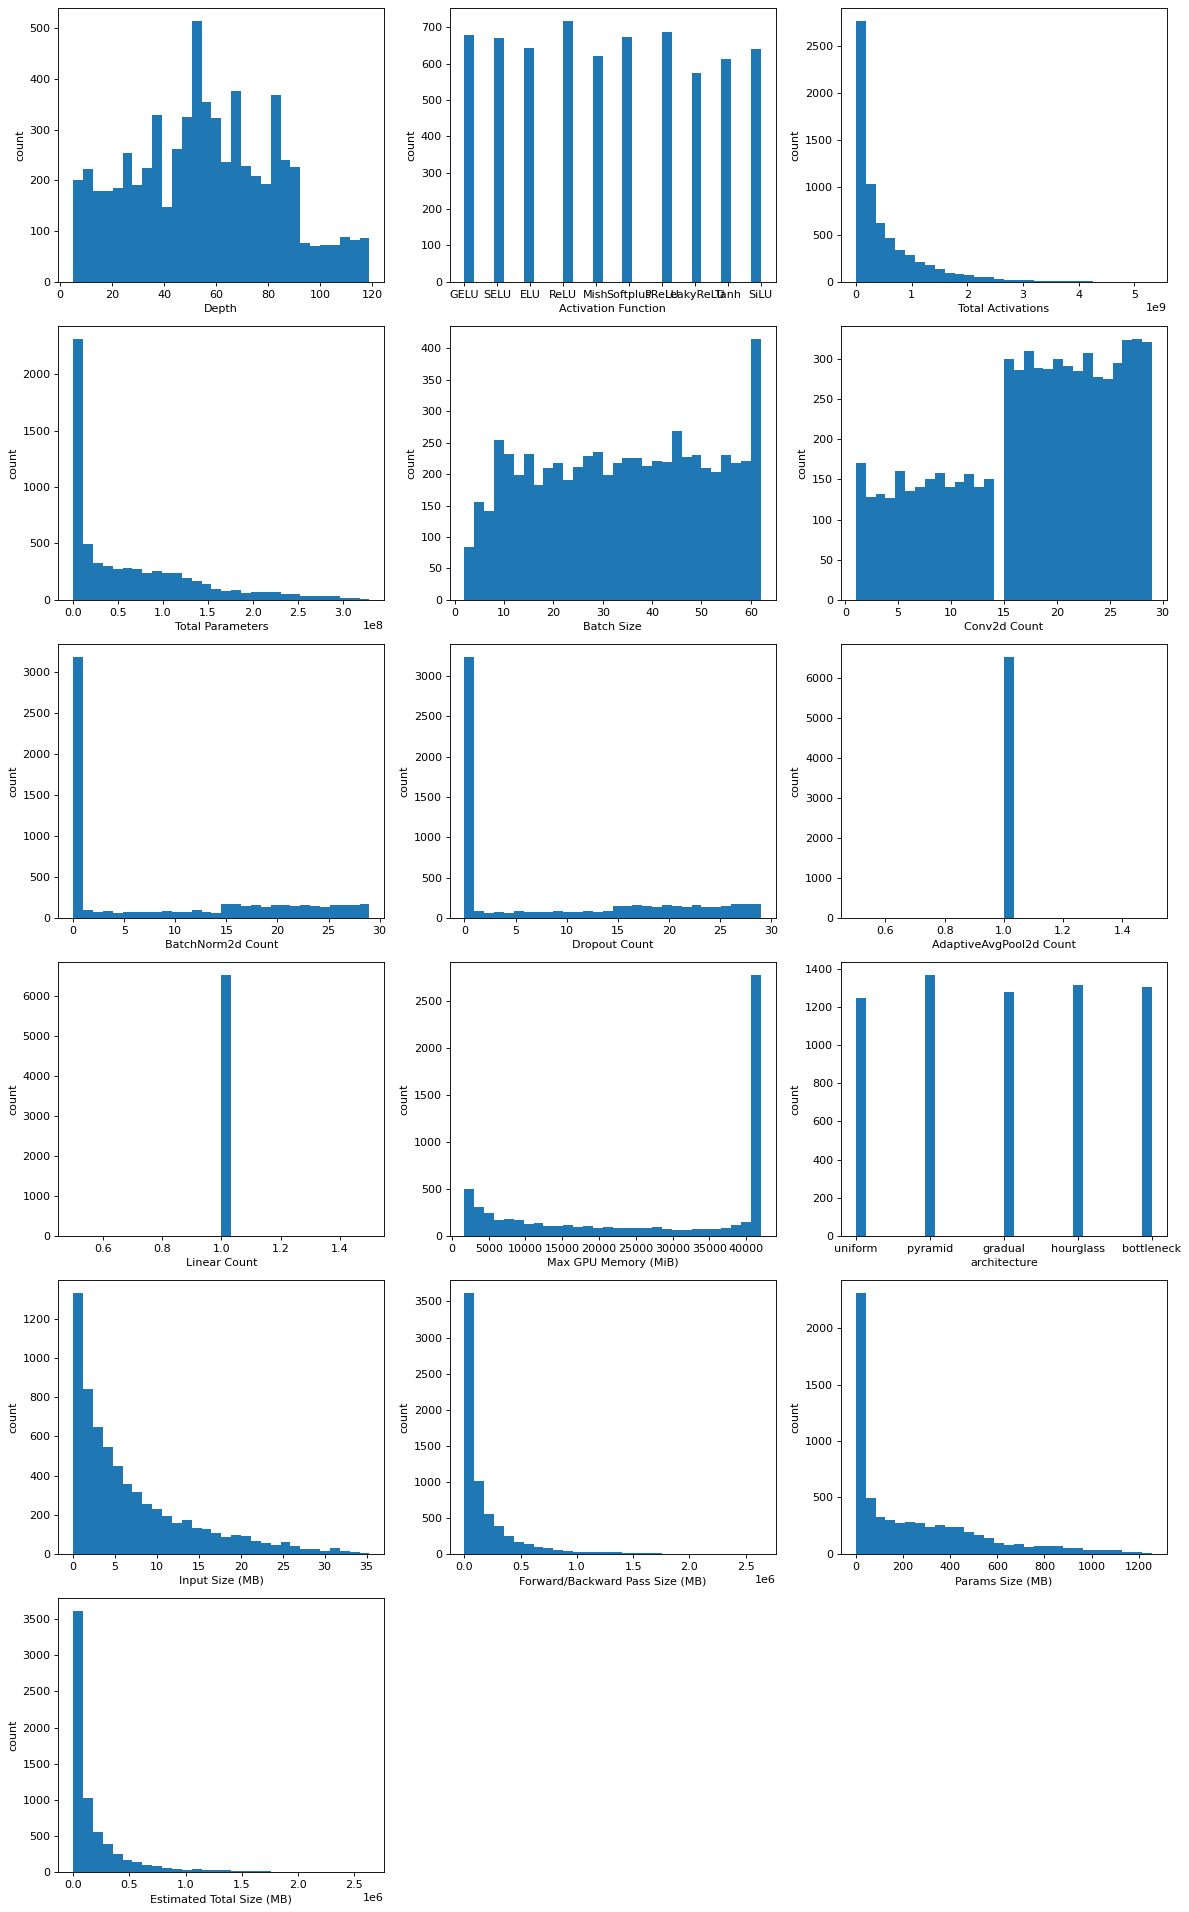

In [ ]:
plot_data_hist(df, exclude_columns=['Total_Activations_Batch_Size'])

# having activations functions as two separate columns

In [ ]:
# List of activation functions
activations = ['ELU', 'GELU', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][1])

# Data after encoding activation functions

In [ ]:
df.head()

,Depth,Activation Function,Total Activations,Total_Activations_Batch_Size,Total Parameters,Batch Size,Conv2d Count,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Max GPU Memory (MiB),architecture,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),activation_encoding_sin,activation_encoding_cos
0,69,GELU,195826172,12141222664,1864805,62,22,0,22,1,1,39517,uniform,21.70,123506.48,7.11,123535.29,0.309017,9.510565e-01
1,47,SELU,306385536,14093734656,32924348,46,11,11,11,1,1,42000,pyramid,2.30,134408.32,125.60,134536.22,0.951057,-3.090170e-01
2,31,ELU,27443119,933066046,1730036,34,14,0,0,1,1,6293,uniform,3.06,10678.04,6.60,10687.70,0.000000,1.000000e+00
3,67,ELU,119603463,1196034630,731920,10,16,16,16,1,1,6475,uniform,2.90,11406.30,2.79,11411.99,0.000000,1.000000e+00
4,39,ReLU,11111315,200003670,2960902,18,12,12,0,1,1,2779,gradual,0.18,2034.54,11.29,2046.01,1.000000,6.123234e-17


# classification

In [ ]:
bins = [0, 8000, 16000, 24000, 32000, 40000, 48000]
labels = [i for i in range(0, len(bins) - 1)]


print("Bins: ", bins, "Number of bins: ", len(bins))
print("Labels: ", labels, "Number of labels: ", len(labels))

df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=True)

df.head()

Bins:  [0, 8000, 16000, 24000, 32000, 40000, 48000] Number of bins:  7
Labels:  [0, 1, 2, 3, 4, 5] Number of labels:  6


,Depth,Activation Function,Total Activations,Total_Activations_Batch_Size,Total Parameters,Batch Size,Conv2d Count,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Max GPU Memory (MiB),architecture,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),activation_encoding_sin,activation_encoding_cos,memory_usage_label
0,69,GELU,195826172,12141222664,1864805,62,22,0,22,1,1,39517,uniform,21.70,123506.48,7.11,123535.29,0.309017,9.510565e-01,4
1,47,SELU,306385536,14093734656,32924348,46,11,11,11,1,1,42000,pyramid,2.30,134408.32,125.60,134536.22,0.951057,-3.090170e-01,5
2,31,ELU,27443119,933066046,1730036,34,14,0,0,1,1,6293,uniform,3.06,10678.04,6.60,10687.70,0.000000,1.000000e+00,0
3,67,ELU,119603463,1196034630,731920,10,16,16,16,1,1,6475,uniform,2.90,11406.30,2.79,11411.99,0.000000,1.000000e+00,0
4,39,ReLU,11111315,200003670,2960902,18,12,12,0,1,1,2779,gradual,0.18,2034.54,11.29,2046.01,1.000000,6.123234e-17,0


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['Depth','Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
        'activation_encoding_cos',
        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)',
        ]].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

total data size:  6516
train size 4561, val size: 1291, test size: 664


In [ ]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store the input and target data
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Returns the total number of samples
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample (input, target pair)
        return self.inputs[idx], self.targets[idx]

train_dataloader = DataLoader(CustomDataset(x_train, y_train), 512, num_workers=2, shuffle=True)
val_dataloader = DataLoader(CustomDataset(x_val, y_val), 512, num_workers=2)
test_dataloader = DataLoader(CustomDataset(x_test, y_test),1, num_workers=1)
x, y = next(iter(train_dataloader))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([512, 10]), output shape: torch.Size([512])


In [ ]:
class FC_base(nn.Module):
    def __init__(self, input_features, output_features, base_features):
        super(FC_base, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(input_features, base_features)
        self.bn1 = nn.BatchNorm1d(base_features)
        self.fc2 = nn.Linear(base_features, base_features)
        self.bn2 = nn.BatchNorm1d(base_features)
        self.fc3 = nn.Linear(base_features, base_features)
        self.bn3 = nn.BatchNorm1d(base_features)
        self.fc4 = nn.Linear(base_features, base_features)
        self.bn4 = nn.BatchNorm1d(base_features)
        self.fc5 = nn.Linear(base_features, base_features)
        self.bn5 = nn.BatchNorm1d(base_features)
        self.fc6 = nn.Linear(base_features, base_features)
        self.bn6 = nn.BatchNorm1d(base_features)

        self.final = nn.Linear(base_features, output_features)
        # self.dropout = nn.Dropout(p=0.0)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.relu(self.bn6(self.fc6(x)))
        x = self.final(x)
        return x

In [ ]:
from pytorch_lightning import seed_everything

seed = 11  # Set your desired seed
seed_everything(seed, workers=True)
torch.use_deterministic_algorithms(False)


INFO:lightning_fabric.utilities.seed:Seed set to 11


In [ ]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=10, output_features=output_size, base_features=9)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()
        self.output_size = output_size

        # Apply weight initialization
        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)  # Xavier uniform initialization
            if module.bias is not None:
                nn.init.zeros_(module.bias)  # Initialize bias to zeros


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        self.log('train_acc', acc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.001)

        # Use a scheduler that doesn't require setting the learning rate explicitly
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
        # return optimizer

In [ ]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
print(len(labels))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=True, mode='min')


classifier_model = classification_gpu_usage(output_size = len(labels)).to(device)

summary(classifier_model, input_size=(10,), device=device)

cuda
6
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 9]              99
       BatchNorm1d-2                    [-1, 9]              18
              ReLU-3                    [-1, 9]               0
            Linear-4                    [-1, 9]              90
       BatchNorm1d-5                    [-1, 9]              18
              ReLU-6                    [-1, 9]               0
            Linear-7                    [-1, 9]              90
       BatchNorm1d-8                    [-1, 9]              18
              ReLU-9                    [-1, 9]               0
           Linear-10                    [-1, 9]              90
      BatchNorm1d-11                    [-1, 9]              18
             ReLU-12                    [-1, 9]               0
           Linear-13                    [-1, 9]              90
      BatchNorm1d-14            

In [ ]:
class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the training loss and accuracy logged during the epoch
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
        self.train_accuracies.append(trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the validation loss and accuracy logged during the epoch
        self.val_losses.append(trainer.callback_metrics["val_loss"].item())
        self.val_accuracies.append(trainer.callback_metrics["val_acc"].item())

    def plot_history(self):
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Training Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
# Initialize the history callback
history_callback = HistoryCallback()

classifier_model.train()

classifier_model.train()
trainer = pl.Trainer(
    max_epochs=600,
    callbacks=[early_stopping, history_callback],
)
# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | FC_base          | 717    | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
717       Trainable params
0         Non-trainable params
717       Total params
0.003     Total estimated model params size (MB)
16        Modules in train mode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.809


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.780


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 1.678


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 1.585


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 1.476


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.395


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 1.291


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.244


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.216


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.170


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 1.076


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.033


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.008


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.964


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.946


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.890


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.872


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.835


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.802


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.739


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.736


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.735


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.684


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.660


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.639


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.618


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.595


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.576


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.566


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.563


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.556


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.536


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.522


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.506


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.496


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.488


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.474


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.474


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.473


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.464


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.446


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.441


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.441


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.433


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.432


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.429


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.428


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.425


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.421


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.417


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.414


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.413


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.413


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.410


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.410


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.407


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.405


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.404


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.403


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.402


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.402


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.402


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.401


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.399


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.397


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.396


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.395


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 30 records. Best score: 0.395. Signaling Trainer to stop.


# How the training went on!

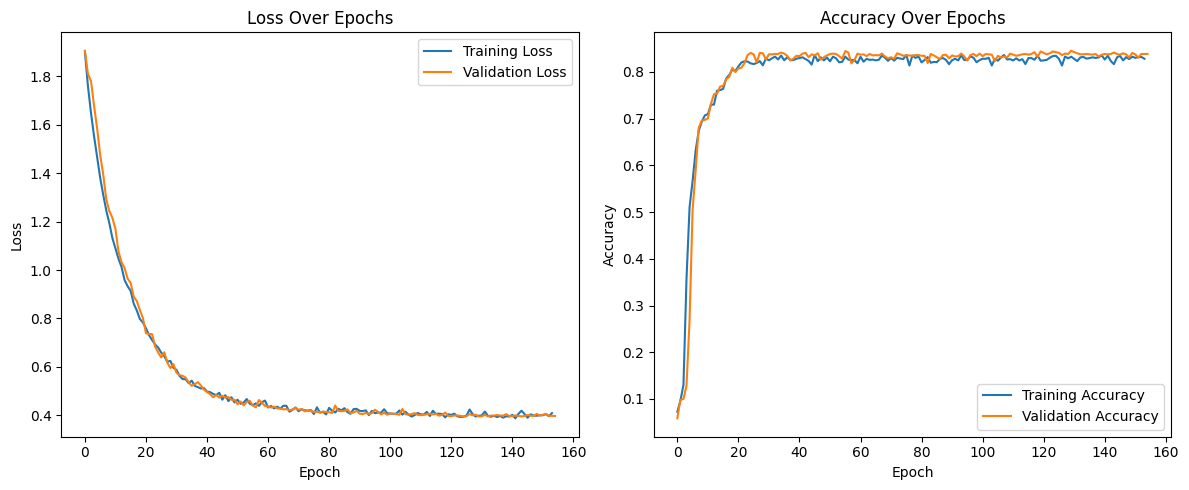

In [ ]:
history_callback.plot_history()

# Saving the model

In [ ]:
# save pytorch lightening model
# trainer.save_checkpoint("cnn_mlp_8g.ckpt")

In [ ]:
# 'Depth','Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
#         'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
#         'activation_encoding_cos'

classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0])
        # if test_data[1].item() != torch.argmax(pred, 1).item():
            # print(test_data[0][0][1])
            # print(f"prediction: {torch.softmax(pred, 1)}, ground truth: {test_data[1]}", (((test_data[0][0][1] * test_data[0][0][4] + test_data[0][0][3]) + (test_data[0][0][3] * test_data[0][0][4]))*4)/(1024**2) )
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
def below_diagonal_sum_rate(confusion_matrix):
    # Convert to a numpy array for easier manipulation if not already
    confusion_matrix = np.array(confusion_matrix)

    # Sum the elements below the main diagonal (excluding the diagonal itself)
    below_diag_sum = np.sum(np.tril(confusion_matrix, k=-1))

    # Get the total number of data points
    total_data_points = np.sum(confusion_matrix)

    # Calculate the rate by dividing below-diagonal sum by total data points
    rate = below_diag_sum / total_data_points

    return rate

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("Below Diagonal Sum Rate: {:.4f}".format(below_diagonal_sum_rate(cm)))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.8494
Precision: 0.8493
Recall: 0.8494
F1-Score: 0.8481
Below Diagonal Sum Rate: 0.0783

Confusion Matrix:
[[130  12   0   0   0   0]
 [  6  75   9   0   0   0]
 [  0  10  28   7   2   0]
 [  0   1  16  27   8   1]
 [  0   0   1  14  28   9]
 [  0   0   0   1   3 276]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       142
         1.0       0.77      0.83      0.80        90
         2.0       0.52      0.60      0.55        47
         3.0       0.55      0.51      0.53        53
         4.0       0.68      0.54      0.60        52
         5.0       0.97      0.99      0.98       280

    accuracy                           0.85       664
   macro avg       0.74      0.73      0.73       664
weighted avg       0.85      0.85      0.85       664

